In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import cv2
import os
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import ImageGrid

In [3]:
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [4]:
mobilenetv2 = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
mobilenetv2.trainable = False

# ImageNet labels
mobilenetv2_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14536120/14536120 [==============================] - 0s 0us/step


In [5]:
nasnet = tf.keras.applications.NASNetMobile(include_top=True,
                                                     weights='imagenet')
nasnet.trainable = False

# ImageNet labels
nasnet_predictions = tf.keras.applications.nasnet.decode_predictions

24227760/24227760 [==============================] - 0s 0us/step


In [6]:
densenet = tf.keras.applications.DenseNet169(include_top=True,
                                                     weights='imagenet')
densenet.trainable = False

# ImageNet labels
densenet_predictions = tf.keras.applications.densenet.decode_predictions

58541896/58541896 [==============================] - 1s 0us/step


In [7]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Function to extract labels from probability vector
def get_imagenet_label(probs):
  return mobilenetv2_predictions(probs, top=1)[0][0]

image_raw = tf.io.read_file(f"/content/gdrive/MyDrive/Data/DAR_data/Object_1/obj6__10.png")
image = tf.image.decode_image(image_raw)
image = preprocess(image)
image_probs = mobilenetv2.predict(image)

import scipy.misc

def display_save_images(image, filename, obj):
  plt.figure()
  plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
  _, image_class, class_confidence = get_imagenet_label(image_probs)
  #scipy.misc.toimage(image).save("/content/gdrive/MyDrive/Data/DAR_data/Pet_object_1/"+str(filename)+".png")
  #ax=fig.add_subplot(1,1,1)
  #extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
  plt.axis('off')
  plt.savefig("/content/gdrive/MyDrive/Data/DAR_data/"+str(filename)+".png", bbox_inches='tight', transparent=True, pad_inches=0)
  plt.show()
  
def display_images(image):
  plt.figure()
  plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
  _, image_class, class_confidence = get_imagenet_label(image_probs)
  plt.show()

1/1 [==============================] - 3s 3s/step


In [8]:
#Create new blank image to build DARs on
#defining the function to clip values
def clip_eps(tensor, eps):
	# clip the values of the tensor to a given range and return it
	return tf.clip_by_value(tensor, clip_value_min=-eps,
		clip_value_max=eps)
 
def create_dars():
  dars = np.zeros(150528)
  dars = dars.reshape(1,224,224,3)
  return dars

car = "Object_1"
cup = "Object_2"
frog = "Object_3"
plate = "Object_4"
tank = "Object_5"
boat = "Object_6"
sandwich = "Object_7"
duck = "Object_8"

def create_adv_dars(obj):
  #Indices of labels
  real_label_index = 751 #Aircraft carrier
  image_probs = mobilenetv2.predict(image)

  #Real label - air carrier
  real_label = tf.one_hot(real_label_index, image_probs.shape[-1])
  real_label = tf.reshape(real_label, (1, image_probs.shape[-1]))

  loss_object = tf.keras.losses.CategoricalCrossentropy()
  input_image = image

  LR = 5e-3
  EPS = 2 / 255.0 #Clipping the delta values so it's not too obvious
  iterations = 5
  epsilons = 4

  #Defining image and optimiser
  delta = tf.Variable(tf.zeros_like(image), trainable=True)
  baseImage = tf.constant(image, dtype=tf.float32)
  #delta2 = tf.constant(image, dtype=tf.float32)
  optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

  dars = create_dars()

  #DAR1
  #performing the (untargeted) optimisation, generating perturbation vector
  for iteration in range(0, iterations):  
    with tf.GradientTape() as tape:
      tape.watch(delta[0,75:90,75:90])   
      adversary = baseImage + delta
      prediction = mobilenetv2(adversary)
 
      real_loss = loss_object(real_label, prediction)
      #target_loss = loss_object(target_label, prediction)
      total_loss = -real_loss

    gradient = tape.gradient(total_loss, delta)
    signed_grad = tf.sign(gradient)

    optimizer.apply_gradients([(gradient, delta)])
    delta.assign_add(clip_eps(delta, eps=EPS))

  dars[0,75:90,75:90] = delta[0,75:90,75:90]

  new_img = image + (dars*10)

  #Predicting with different models
  image_probs_mobilenetv2 = mobilenetv2.predict(new_img)
  _, image_class_m, class_confidence_m = get_imagenet_label(image_probs_mobilenetv2)
  print(mobilenetv2_predictions(mobilenetv2.predict(new_img)))

  image_probs_nasnet = nasnet.predict(new_img)
  _, image_class_n, class_confidence_n = get_imagenet_label(image_probs_nasnet)

  #Saving to array
  imgclassmobilenet.append(image_class_m)
  predsmobilenet.append(class_confidence_m)
  imgclassnasnet.append(image_class_n)
  predsnasnet.append(class_confidence_n)

  display_save_images(new_img, file, obj) 
  return new_img

In [9]:
def create_dar(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = mobilenetv2(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

#gradient_mags = create_dar(image, label)

np.random.seed(1)

def gen_mod_results():
  results = pd.DataFrame(
    {'size_val': size_val,
     'num_val': num_val,
     'imgclassmobilenet': imgclassmobilenet,
     'predsmobilenet': predsmobilenet,  
     'imgclassmobilenet_top2': imgclassmobilenet_top2,
     'predsmobilenet_top2': predsmobilenet_top2,
     'imgclassmobilenet_top3': imgclassmobilenet_top3,
     'predsmobilenet_top3': predsmobilenet_top3,
     'imgclassnasnet': imgclassnasnet,
     'predsnasnet': predsnasnet,
     'imgclassnasnet_top2': imgclassnasnet_top2,
     'predsnasnet_top2': predsnasnet_top2,  
     'imgclassnasnet_top3': imgclassnasnet_top3,
     'predsnasnet_top3': predsnasnet_top3,  
     'imgclassdensenet': imgclassdensenet,
     'predsdensenet': predsdensenet,
     'imgclassdensenet_top2': imgclassdensenet_top2,
     'predsdensenet_top2': predsdensenet_top2,
     'imgclassdensenet_top3': imgclassdensenet_top3,
     'predsdensenet_top3': predsdensenet_top3
    })
  return results

def gen_mod_results_pet():
  results = pd.DataFrame(
    {'size_val': size_val,
     'num_val': num_val,
     'imgclassmobilenetpet': imgclassmobilenetpet,
     'predsmobilenetpet': predsmobilenetpet,
     'imgclassmobilenetpet_top2': imgclassmobilenetpet_top2,
     'predsmobilenetpet_top2': predsmobilenetpet_top2,
     'imgclassmobilenetpet_top3': imgclassmobilenetpet_top3,
     'predsmobilenetpet_top3': predsmobilenetpet_top3,
     'imgclassnasnetpet': imgclassnasnetpet,
     'predsnasnetpet': predsnasnetpet,
     'imgclassnasnetpet_top2': imgclassnasnetpet_top2,
     'predsnasnetpet_top2': predsnasnetpet_top2,
     'imgclassnasnetpet_top3': imgclassnasnetpet_top3,
     'predsnasnetpet_top3': predsnasnetpet_top3,
     'imgclassdensenetpet': imgclassdensenetpet,
     'predsdensenetpet': predsdensenetpet,
     'imgclassdensenetpet_top2': imgclassdensenetpet_top2,
     'predsdensenetpet_top2': predsdensenetpet_top2,
     'imgclassdensenetpet_top3': imgclassdensenetpet_top3,
     'predsdensenetpet_top3': predsdensenetpet_top3
    })
  return results

In [10]:
def gen_results(): #Note there is another gen results function above that saves results from different models
  results = pd.DataFrame(
    {'x_value': x_value,
     'y_value': y_value,
     'confidence': conf_results,
     'include' : include
    })
  #results.loc[(results['x_value'] >x_excl) & (results['x_value'] <(x_excl+x_len)), 'include'] = 0 #Set values in ship area to 0 (not include)
  #results.loc[(results['y_value'] >y_excl) & (results['y_value'] <(y_excl+y_len)), 'include'] = 0
  #results.to_csv("/content/gdrive/MyDrive/PhD/Chapter 1 - AML attack/results.csv", sep='\t')
  return results

In [17]:
def adv_dar(input_image):
    epsilons = 4
    x_start = 0
    y_start = 0
    pixel_max = 224
    interval= 30 #Distance for which the squares are shifted and sampled
    iterations = 1000 #Max number of loops to try over image (change below for DAR creation)
    delta = tf.Variable(tf.zeros_like(image), trainable=True)
    accuracy = tf.Variable(tf.zeros_like([]), tf.int32)
    baseImage = tf.constant(image, dtype=tf.float32)
    LR = 5e-3
    EPS = 2 / 255.0 #Clipping the delta values so it's not too obvious
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    real_label = tf.one_hot(real_label_index, image_probs.shape[-1])
    real_label = tf.reshape(real_label, (1, image_probs.shape[-1]))

    for iteration in range(0, iterations):  
      #for i in range(x_start, iterations):
      dars = create_dars()
      with tf.GradientTape() as tape:
        tape.watch(delta[0,y_start:y_start+interval,x_start:x_start+interval])   
        adversary = baseImage + delta
        prediction = mobilenetv2(adversary)
        real_loss = loss_object(real_label, prediction)
        #target_loss = loss_object(target_label, prediction)
        total_loss = -real_loss
      gradient = tape.gradient(total_loss, delta)
      signed_grad = tf.sign(gradient)
      optimizer.apply_gradients([(gradient, delta)])
      delta.assign_add(clip_eps(delta, eps=EPS))
      dars[0,y_start:y_start+interval,x_start:x_start+interval] = delta[0,y_start:y_start+interval,x_start:x_start+interval]
      new_img = image + (dars*10)
      _, image_class, class_confidence = mobilenetv2_predictions(mobilenetv2.predict(new_img), top=1)[0][0]
      #display_images(new_img)
      #print(x_start)
      #print(y_start)
      #print(class_confidence) 
      x_value.append(x_start)
      y_value.append(y_start)
      conf_results.append(class_confidence)      
      if x_start <= 230:
          x_start= x_start+interval
      elif y_start <=230:
          x_start = 0
          y_start = y_start + interval
      elif y_start > 230: 
          break

    return x_start,class_confidence
    return x_value, y_value, conf_results
    
def create_adv_dars_auto(s, n):
  real_label = tf.one_hot(real_label_index, image_probs.shape[-1])
  real_label = tf.reshape(real_label, (1, image_probs.shape[-1]))

  loss_object = tf.keras.losses.CategoricalCrossentropy()

  size = s
  number = n

  q=lambda a: (abs(a)+a)/2 #Function to set number as positive or zero when blurring dars

  #Variables
  input_image = image
  LR = 5e-3
  EPS = 2 / 255.0 #Clipping the delta values so it's not too obvious

  #Defining image and optimiser
  delta = tf.Variable(tf.zeros_like(image), trainable=True)
  accuracy = tf.Variable(tf.zeros_like([]), tf.int32)
  baseImage = tf.constant(image, dtype=tf.float32)
  #delta2 = tf.constant(image, dtype=tf.float32)
  optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

  #Defining function that calculated confidence based on iterating through regions

  results = gen_results()

  #results.to_csv("/content/gdrive/MyDrive/PhD/Chapter 1 - AML attack/"+Obj+"results.csv", sep='\t')

  x1 = results.loc[results['confidence'].idxmin()]['x_value']
  y1 = results.loc[results['confidence'].idxmin()]['y_value']
  results.loc[results.x_value == x1, 'include'] = "0"
  results.loc[results.y_value == y1, 'include'] = "0"

  c2 = results[results['include']==1]
  x2 = c2.loc[c2['confidence'].idxmin()]['x_value']
  y2 = c2.loc[c2['confidence'].idxmin()]['y_value']
  c2.loc[c2.x_value == x2, 'include'] = "0"
  c2.loc[c2.y_value == y2, 'include'] = "0"

  c3 = c2[c2['include']==1]
  x3 = c3.loc[c3['confidence'].idxmin()]['x_value']
  y3 = c3.loc[c3['confidence'].idxmin()]['y_value']
  c3.loc[c3.x_value == x3, 'include'] = "0"
  c3.loc[c3.y_value == y3, 'include'] = "0"

  c4 = c3[c3['include']==1]
  x4 = c4.loc[c4['confidence'].idxmin()]['x_value']
  y4 = c4.loc[c4['confidence'].idxmin()]['y_value']

  x1 = int(x1)
  x2 = int(x2)
  x3 = int(x3)
  x4 = int(x4)
  y1 = int(y1)
  y2 = int(y2)
  y3 = int(y3)
  y4 = int(y4)

  if number ==1:
    #Set up
    x_cen_1 = x1
    y_cen_1 = y1
    dars = create_dars()
    iterations = 20 #Iterations to optimise DARs (different to iterations above). Note increasing this makes it very slow so do that last.

    for iteration in range(0, iterations):  
      with tf.GradientTape() as tape:
        tape.watch(delta[0,y_cen_1-int(size/2):y_cen_1+int(size/2),x_cen_1-int(size/2):x_cen_1+int(size/2)])   
        adversary = baseImage + delta
        prediction = model(adversary)

        real_loss = loss_object(real_label, prediction)
        #target_loss = loss_object(target_label, prediction)
        total_loss = -real_loss

      gradient = tape.gradient(total_loss, delta)
      signed_grad = tf.sign(gradient)

      optimizer.apply_gradients([(gradient, delta)])
      delta.assign_add(clip_eps(delta, eps=EPS))

    dars[0,y_cen_1-int(size/2):y_cen_1+int(size/2),x_cen_1-int(size/2):x_cen_1+int(size/2)] = delta[0,y_cen_1-int(size/2):y_cen_1+int(size/2),x_cen_1-int(size/2):x_cen_1+int(size/2)]
    blur1 = cv2.blur(dars[0,int(q(y_cen_1-int(size/2))):y_cen_1+int(size/2),int(q(x_cen_1-int(size/2))):x_cen_1+int(size/2)],(3,3))
    dars[0,int(q(y_cen_1-int(size/2))):y_cen_1+int(size/2),int(q(x_cen_1-int(size/2))):x_cen_1+int(size/2)] = blur1
    #This method using averaging by convolving the image with a normalized box filter

  if number == 2:
    #Set up
    x_cen_1 = x1
    y_cen_1 = y1
    dars = create_dars()
    iterations = 20 #Iterations to optimise DARs (different to iterations above). Note increasing this makes it very slow so do that last.

    for iteration in range(0, iterations):  
      with tf.GradientTape() as tape:
        tape.watch(delta[0,y_cen_1-int(size/2):y_cen_1+int(size/2),x_cen_1-int(size/2):x_cen_1+int(size/2)])   
        adversary = baseImage + delta
        prediction = model(adversary)

        real_loss = loss_object(real_label, prediction)
        #target_loss = loss_object(target_label, prediction)
        total_loss = -real_loss

      gradient = tape.gradient(total_loss, delta)
      signed_grad = tf.sign(gradient)

      optimizer.apply_gradients([(gradient, delta)])
      delta.assign_add(clip_eps(delta, eps=EPS))

    dars[0,y_cen_1-int(size/2):y_cen_1+int(size/2),x_cen_1-int(size/2):x_cen_1+int(size/2)] = delta[0,y_cen_1-int(size/2):y_cen_1+int(size/2),x_cen_1-int(size/2):x_cen_1+int(size/2)]
    blur1 = cv2.blur(dars[0,int(q(y_cen_1-int(size/2))):y_cen_1+int(size/2),int(q(x_cen_1-int(size/2))):x_cen_1+int(size/2)],(3,3))
    dars[0,int(q(y_cen_1-int(size/2))):y_cen_1+int(size/2),int(q(x_cen_1-int(size/2))):x_cen_1+int(size/2)] = blur1
    #This method using averaging by convolving the image with a normalized box filter

    #DAR2 based on minimum calculated prior
    x_cen_2 = x2
    y_cen_2 = y2
    #performing the (untargeted) optimisation, generating perturbation vector
    for iteration in range(0, iterations):  
      with tf.GradientTape() as tape:
        tape.watch(delta[0,y_cen_2-int(size/2):y_cen_2+int(size/2),x_cen_2-int(size/2):x_cen_2+int(size/2)])   
        adversary = baseImage + delta
        prediction = model(adversary)
    
        real_loss = loss_object(real_label, prediction)
        #target_loss = loss_object(target_label, prediction)
        total_loss = -real_loss

      gradient = tape.gradient(total_loss, delta)
      signed_grad = tf.sign(gradient)

      optimizer.apply_gradients([(gradient, delta)])
      delta.assign_add(clip_eps(delta, eps=EPS))

    dars[0,y_cen_2-int(size/2):y_cen_2+int(size/2),x_cen_2-int(size/2):x_cen_2+int(size/2)] = delta[0,y_cen_2-int(size/2):y_cen_2+int(size/2),x_cen_2-int(size/2):x_cen_2+int(size/2)]
    blur2 = cv2.blur(dars[0,int(q(y_cen_2-int(size/2))):y_cen_2+int(size/2),int(q(x_cen_2-int(size/2))):x_cen_2+int(size/2)],(3,3))
    dars[0,int(q(y_cen_2-int(size/2))):y_cen_2+int(size/2),int(q(x_cen_2-int(size/2))):x_cen_2+int(size/2)] = blur2
    #This method using averaging by convolving the image with a normalized box filter\

  elif number == 3:
    #DAR1
    x_cen_1 = x1
    y_cen_1 = y1
    dars = create_dars()
    iterations = 20 #Iterations to optimise DARs (different to iterations above). Note increasing this makes it very slow so do that last.

    for iteration in range(0, iterations):  
      with tf.GradientTape() as tape:
        tape.watch(delta[0,y_cen_1-int(size/2):y_cen_1+int(size/2),x_cen_1-int(size/2):x_cen_1+int(size/2)])   
        adversary = baseImage + delta
        prediction = model(adversary)

        real_loss = loss_object(real_label, prediction)
        #target_loss = loss_object(target_label, prediction)
        total_loss = -real_loss

      gradient = tape.gradient(total_loss, delta)
      signed_grad = tf.sign(gradient)

      optimizer.apply_gradients([(gradient, delta)])
      delta.assign_add(clip_eps(delta, eps=EPS))

    dars[0,y_cen_1-int(size/2):y_cen_1+int(size/2),x_cen_1-int(size/2):x_cen_1+int(size/2)] = delta[0,y_cen_1-int(size/2):y_cen_1+int(size/2),x_cen_1-int(size/2):x_cen_1+int(size/2)]
    blur1 = cv2.blur(dars[0,int(q(y_cen_1-int(size/2))):y_cen_1+int(size/2),int(q(x_cen_1-int(size/2))):x_cen_1+int(size/2)],(3,3))
    dars[0,int(q(y_cen_1-int(size/2))):y_cen_1+int(size/2),int(q(x_cen_1-int(size/2))):x_cen_1+int(size/2)] = blur1
    #This method using averaging by convolving the image with a normalized box filter

    #DAR2 based on minimum calculated prior
    x_cen_2 = x2
    y_cen_2 = y2
    #performing the (untargeted) optimisation, generating perturbation vector
    for iteration in range(0, iterations):  
      with tf.GradientTape() as tape:
        tape.watch(delta[0,y_cen_2-int(size/2):y_cen_2+int(size/2),x_cen_2-int(size/2):x_cen_2+int(size/2)])   
        adversary = baseImage + delta
        prediction = model(adversary)
    
        real_loss = loss_object(real_label, prediction)
        #target_loss = loss_object(target_label, prediction)
        total_loss = -real_loss

      gradient = tape.gradient(total_loss, delta)
      signed_grad = tf.sign(gradient)

      optimizer.apply_gradients([(gradient, delta)])
      delta.assign_add(clip_eps(delta, eps=EPS))

    dars[0,y_cen_2-int(size/2):y_cen_2+int(size/2),x_cen_2-int(size/2):x_cen_2+int(size/2)] = delta[0,y_cen_2-int(size/2):y_cen_2+int(size/2),x_cen_2-int(size/2):x_cen_2+int(size/2)]
    blur2 = cv2.blur(dars[0,int(q(y_cen_2-int(size/2))):y_cen_2+int(size/2),int(q(x_cen_2-int(size/2))):x_cen_2+int(size/2)],(3,3))
    dars[0,int(q(y_cen_2-int(size/2))):y_cen_2+int(size/2),int(q(x_cen_2-int(size/2))):x_cen_2+int(size/2)] = blur2
    #This method using averaging by convolving the image with a normalized box filter\

    #DAR3 based on minimum calculated prior
    x_cen_3 = x3
    y_cen_3 = y3
    #performing the (untargeted) optimisation, generating perturbation vector
    for iteration in range(0, iterations):  
      with tf.GradientTape() as tape:
        tape.watch(delta[0,y_cen_3-int(size/2):y_cen_3+int(size/2),x_cen_3-int(size/2):x_cen_3+int(size/2)])   
        adversary = baseImage + delta
        prediction = model(adversary)
    
        real_loss = loss_object(real_label, prediction)
        #target_loss = loss_object(target_label, prediction)
        total_loss = -real_loss

      gradient = tape.gradient(total_loss, delta)
      signed_grad = tf.sign(gradient)

      optimizer.apply_gradients([(gradient, delta)])
      delta.assign_add(clip_eps(delta, eps=EPS))

    dars[0,y_cen_3-int(size/2):y_cen_3+int(size/2),x_cen_3-int(size/2):x_cen_3+int(size/2)] = delta[0,y_cen_3-int(size/2):y_cen_3+int(size/2),x_cen_3-int(size/2):x_cen_3+int(size/2)]
    blur3 = cv2.blur(dars[0,int(q(y_cen_3-int(size/2))):y_cen_3+int(size/2),int(q(x_cen_3-int(size/2))):x_cen_3+int(size/2)],(3,3))
    dars[0,int(q(y_cen_3-int(size/2))):y_cen_3+int(size/2),int(q(x_cen_3-int(size/2))):x_cen_3+int(size/2)] = blur3
    #This method using averaging by convolving the image with a normalized box filter

  if number == 4:
    #DAR1
    x_cen_1 = x1
    y_cen_1 = y1
    dars = create_dars()
    iterations = 20 #Iterations to optimise DARs (different to iterations above). Note increasing this makes it very slow so do that last.

    for iteration in range(0, iterations):  
      with tf.GradientTape() as tape:
        tape.watch(delta[0,y_cen_1-int(size/2):y_cen_1+int(size/2),x_cen_1-int(size/2):x_cen_1+int(size/2)])   
        adversary = baseImage + delta
        prediction = model(adversary)

        real_loss = loss_object(real_label, prediction)
        #target_loss = loss_object(target_label, prediction)
        total_loss = -real_loss

      gradient = tape.gradient(total_loss, delta)
      signed_grad = tf.sign(gradient)

      optimizer.apply_gradients([(gradient, delta)])
      delta.assign_add(clip_eps(delta, eps=EPS))

    dars[0,y_cen_1-int(size/2):y_cen_1+int(size/2),x_cen_1-int(size/2):x_cen_1+int(size/2)] = delta[0,y_cen_1-int(size/2):y_cen_1+int(size/2),x_cen_1-int(size/2):x_cen_1+int(size/2)]
    blur1 = cv2.blur(dars[0,int(q(y_cen_1-int(size/2))):y_cen_1+int(size/2),int(q(x_cen_1-int(size/2))):x_cen_1+int(size/2)],(3,3))
    dars[0,int(q(y_cen_1-int(size/2))):y_cen_1+int(size/2),int(q(x_cen_1-int(size/2))):x_cen_1+int(size/2)] = blur1
    #This method using averaging by convolving the image with a normalized box filter

    #DAR2 based on minimum calculated prior
    x_cen_2 = x2
    y_cen_2 = y2
    #performing the (untargeted) optimisation, generating perturbation vector
    for iteration in range(0, iterations):  
      with tf.GradientTape() as tape:
        tape.watch(delta[0,y_cen_2-int(size/2):y_cen_2+int(size/2),x_cen_2-int(size/2):x_cen_2+int(size/2)])   
        adversary = baseImage + delta
        prediction = model(adversary)
    
        real_loss = loss_object(real_label, prediction)
        #target_loss = loss_object(target_label, prediction)
        total_loss = -real_loss

      gradient = tape.gradient(total_loss, delta)
      signed_grad = tf.sign(gradient)

      optimizer.apply_gradients([(gradient, delta)])
      delta.assign_add(clip_eps(delta, eps=EPS))

    dars[0,y_cen_2-int(size/2):y_cen_2+int(size/2),x_cen_2-int(size/2):x_cen_2+int(size/2)] = delta[0,y_cen_2-int(size/2):y_cen_2+int(size/2),x_cen_2-int(size/2):x_cen_2+int(size/2)]
    blur2 = cv2.blur(dars[0,int(q(y_cen_2-int(size/2))):y_cen_2+int(size/2),int(q(x_cen_2-int(size/2))):x_cen_2+int(size/2)],(3,3))
    dars[0,int(q(y_cen_2-int(size/2))):y_cen_2+int(size/2),int(q(x_cen_2-int(size/2))):x_cen_2+int(size/2)] = blur2
    #This method using averaging by convolving the image with a normalized box filter\

    #DAR3 based on minimum calculated prior
    x_cen_3 = x3
    y_cen_3 = y3
    #performing the (untargeted) optimisation, generating perturbation vector
    for iteration in range(0, iterations):  
      with tf.GradientTape() as tape:
        tape.watch(delta[0,y_cen_3-int(size/2):y_cen_3+int(size/2),x_cen_3-int(size/2):x_cen_3+int(size/2)])   
        adversary = baseImage + delta
        prediction = model(adversary)
    
        real_loss = loss_object(real_label, prediction)
        #target_loss = loss_object(target_label, prediction)
        total_loss = -real_loss

      gradient = tape.gradient(total_loss, delta)
      signed_grad = tf.sign(gradient)

      optimizer.apply_gradients([(gradient, delta)])
      delta.assign_add(clip_eps(delta, eps=EPS))
    
    dars[0,y_cen_3-int(size/2):y_cen_3+int(size/2),x_cen_3-int(size/2):x_cen_3+int(size/2)] = delta[0,y_cen_3-int(size/2):y_cen_3+int(size/2),x_cen_3-int(size/2):x_cen_3+int(size/2)]
    blur3 = cv2.blur(dars[0,int(q(y_cen_3-int(size/2))):y_cen_3+int(size/2),int(q(x_cen_3-int(size/2))):x_cen_3+int(size/2)],(3,3))
    dars[0,int(q(y_cen_3-int(size/2))):y_cen_3+int(size/2),int(q(x_cen_3-int(size/2))):x_cen_3+int(size/2)] = blur3

    #DAR4 based on minimum calculated prior
    x_cen_4 = x4
    y_cen_4 = y4
    #performing the (untargeted) optimisation, generating perturbation vector
    for iteration in range(0, iterations):  
      with tf.GradientTape() as tape:
        tape.watch(delta[0,y_cen_4-int(size/2):y_cen_4+int(size/2),x_cen_4-int(size/2):x_cen_4+int(size/2)])   
        adversary = baseImage + delta
        prediction = model(adversary)
    
        real_loss = loss_object(real_label, prediction)
        #target_loss = loss_object(target_label, prediction)
        total_loss = -real_loss

      gradient = tape.gradient(total_loss, delta)
      signed_grad = tf.sign(gradient)

      optimizer.apply_gradients([(gradient, delta)])
      delta.assign_add(clip_eps(delta, eps=EPS))

    dars[0,y_cen_4-int(size/2):y_cen_4+int(size/2),x_cen_4-int(size/2):x_cen_4+int(size/2)] = delta[0,y_cen_4-int(size/2):y_cen_4+int(size/2),x_cen_4-int(size/2):x_cen_4+int(size/2)]
    blur4 = cv2.blur(dars[0,int(q(y_cen_4-int(size/2))):y_cen_4+int(size/2),int(q(x_cen_4-int(size/2))):x_cen_4+int(size/2)],(3,3))
    dars[0,int(q(y_cen_4-int(size/2))):y_cen_4+int(size/2),int(q(x_cen_4-int(size/2))):x_cen_4+int(size/2)] = blur4
    #This method using averaging by convolving the image with a normalized box filter

  else:
    print("Only calculates 1-4 DARS")

  f = "Pet_images/"+Obj+"_DARS_"+str(size)+"_"+str(number)+str({file})
  new_img = image + (dars*10)
  display_save_images(new_img, f, Obj)


  #Predicting with different models
  print(mobilenetv2_predictions(mobilenetv2.predict(new_img)))
  print(nasnet_predictions(nasnet.predict(new_img)))
  print(densenet_predictions(densenet.predict(new_img)))

  display_images(image)
  print(mobilenetv2_predictions(mobilenetv2.predict(image)))
  print(nasnet_predictions(nasnet.predict(image)))
  print(densenet_predictions(densenet.predict(image)))


  #Save results for pet images
  #Mobilenet
  #image_probs_mobilenet = mobilenetv2.predict(new_img)
  #_, image_class, class_confidence = get_imagenet_label(image_probs_mobilenet)
  top1_class = mobilenetv2_predictions(mobilenetv2.predict(new_img))[0][0][1]
  print(top1_class)
  top1_pred = mobilenetv2_predictions(mobilenetv2.predict(new_img))[0][0][2]
  print(top1_pred)
  top2_class = mobilenetv2_predictions(mobilenetv2.predict(new_img))[0][1][1]
  print(top2_class)
  top2_pred = mobilenetv2_predictions(mobilenetv2.predict(new_img))[0][1][2]
  print(top2_pred)
  top3_class = mobilenetv2_predictions(mobilenetv2.predict(new_img))[0][2][1]
  print(top3_class)
  top3_pred = mobilenetv2_predictions(mobilenetv2.predict(new_img))[0][2][2]
  print(top3_pred)
  imgclassmobilenetpet.append(top1_class)
  predsmobilenetpet.append(top1_pred)
  imgclassmobilenetpet_top2.append(top2_class)
  predsmobilenetpet_top2.append(top2_pred)
  imgclassmobilenetpet_top3.append(top3_class)
  predsmobilenetpet_top3.append(top3_pred)

  #Nasnet
  top1_class = nasnet_predictions(nasnet.predict(new_img))[0][0][1]
  top1_pred = nasnet_predictions(nasnet.predict(new_img))[0][0][2]
  top2_class = nasnet_predictions(nasnet.predict(new_img))[0][1][1]
  top2_pred = nasnet_predictions(nasnet.predict(new_img))[0][1][2]
  top3_class = nasnet_predictions(nasnet.predict(new_img))[0][2][1]
  top3_pred = nasnet_predictions(nasnet.predict(new_img))[0][2][2]
  imgclassnasnetpet.append(top1_class)
  predsnasnetpet.append(top1_pred)
  imgclassnasnetpet_top2.append(top2_class)
  predsnasnetpet_top2.append(top2_pred)
  imgclassnasnetpet_top3.append(top3_class)
  predsnasnetpet_top3.append(top3_pred)

  #Densenet
  top1_class = densenet_predictions(densenet.predict(new_img))[0][0][1]
  top1_pred = densenet_predictions(densenet.predict(new_img))[0][0][2]
  top2_class = densenet_predictions(densenet.predict(new_img))[0][1][1]
  top2_pred = densenet_predictions(densenet.predict(new_img))[0][1][2]
  top3_class = densenet_predictions(densenet.predict(new_img))[0][2][1]
  top3_pred = densenet_predictions(densenet.predict(new_img))[0][2][2]
  imgclassdensenetpet.append(top1_class)
  predsdensenetpet.append(top1_pred)
  imgclassdensenetpet_top2.append(top2_class)
  predsdensenetpet_top2.append(top2_pred)
  imgclassdensenetpet_top3.append(top3_class)
  predsdensenetpet_top3.append(top3_pred)

  #Save results for clean images
  #Mobilenet
  #image_probs_mobilenet = mobilenetv2.predict(image)
  #_, image_class, class_confidence = get_imagenet_label(image_probs_mobilenet)
  top1_class = mobilenetv2_predictions(mobilenetv2.predict(image))[0][0][1]
  print(top1_class)
  top1_pred = mobilenetv2_predictions(mobilenetv2.predict(image))[0][0][2]
  print(top1_pred)
  top2_class = mobilenetv2_predictions(mobilenetv2.predict(image))[0][1][1]
  print(top2_class)
  top2_pred = mobilenetv2_predictions(mobilenetv2.predict(image))[0][1][2]
  print(top2_pred)
  top3_class = mobilenetv2_predictions(mobilenetv2.predict(image))[0][2][1]
  print(top3_class)
  top3_pred = mobilenetv2_predictions(mobilenetv2.predict(image))[0][2][2]
  print(top3_pred)
  imgclassmobilenet.append(top1_class)
  predsmobilenet.append(top1_pred)
  imgclassmobilenet_top2.append(top2_class)
  predsmobilenet_top2.append(top2_pred)
  imgclassmobilenet_top3.append(top3_class)
  predsmobilenet_top3.append(top3_pred)


  #Nasnet
  top1_class = nasnet_predictions(nasnet.predict(image))[0][0][1]
  top1_pred = nasnet_predictions(nasnet.predict(image))[0][0][2]
  top2_class = nasnet_predictions(nasnet.predict(image))[0][1][1]
  top2_pred = nasnet_predictions(nasnet.predict(image))[0][1][2]
  top3_class = nasnet_predictions(nasnet.predict(image))[0][2][1]
  top3_pred = nasnet_predictions(nasnet.predict(image))[0][2][2]
  imgclassnasnet.append(top1_class)
  predsnasnet.append(top1_pred)
  imgclassnasnet_top2.append(top2_class)
  predsnasnet_top2.append(top2_pred)
  imgclassnasnet_top3.append(top3_class)
  predsnasnet_top3.append(top3_pred)

  #Densenet
  top1_class = densenet_predictions(densenet.predict(image))[0][0][1]
  top1_pred = densenet_predictions(densenet.predict(image))[0][0][2]
  top2_class = densenet_predictions(densenet.predict(image))[0][1][1]
  top2_pred = densenet_predictions(densenet.predict(image))[0][1][2]
  top3_class = densenet_predictions(densenet.predict(image))[0][2][1]
  top3_pred = densenet_predictions(densenet.predict(image))[0][2][2]
  imgclassdensenet.append(top1_class)
  predsdensenet.append(top1_pred)
  imgclassdensenet_top2.append(top2_class)
  predsdensenet_top2.append(top2_pred)
  imgclassdensenet_top3.append(top3_class)
  predsdensenet_top3.append(top3_pred)

  #Save size and number
  size_val.append(size)
  num_val.append(number)

  return imgclassmobilenet, predsmobilenet, imgclassmobilenet_top2, predsmobilenet_top2, imgclassmobilenet_top3, predsmobilenet_top3,
  imgclassmobilenetpet, predsmobilenetpet, imgclassmobilenetpet_top2, predsmobilenetpet_top2, imgclassmobilenetpet_top3, predsmobilenetpet_top3,    
  imgclassnasnet, predsnasnet, imgclassnasnet_top2, predsnasnet_top2, imgclassnasnet_top3, predsnasnet_top3,
  imgclassnasnetpet, predsnasnetpet, imgclassnasnetpet_top2, predsnasnetpet_top2, imgclassnasnetpet_top3, predsnasnetpet_top3, 
  imgclassdensenet, predsdensenet, imgclassdensenet_top2, predsdensenet_top2, imgclassdensenet_top3, predsdensenet_top3, 
  imgclassdensenetpet, predsdensenetpet, imgclassdensenetpet_top2, predsdensenetpet_top2,  imgclassdensenetpet_top3, predsdensenetpet_top3  

# COIL images

In [18]:
size = 10 #Need to check it goes through every combination of size and number. Also check that number = 1,2,3,4 (it's only 2 or 3)
number = 3
#for i,size in enumerate(size):
  #All this stuff gets changed for each image
real_label_index = 751 #Racer
Obj = 'COIL'
#im1_raw = tf.io.read_file(f"/content/gdrive/MyDrive/Data/DAR_data/imagenet_racer.JPEG")

files = os.listdir("/content/gdrive/MyDrive/Data/DAR_data/COIL_Images")

model = mobilenetv2
x_value = []
y_value = []
size_val = []
num_val = []
conf_results = []
imgclassmobilenetpet = []
predsmobilenetpet = []
imgclassmobilenetpet_top2 = []
predsmobilenetpet_top2 = []
imgclassmobilenetpet_top3 = []
predsmobilenetpet_top3 = []
imgclassnasnetpet = []
predsnasnetpet = []
imgclassnasnetpet_top2 = []
predsnasnetpet_top2 = []
imgclassnasnetpet_top3 = []
predsnasnetpet_top3 = []
imgclassdensenetpet = []
predsdensenetpet = []  
imgclassdensenetpet_top2 = []
predsdensenetpet_top2 = []
imgclassdensenetpet_top3 = []
predsdensenetpet_top3 = []
imgclassmobilenet = []
predsmobilenet = []
imgclassmobilenet_top2 = []
predsmobilenet_top2 = []
imgclassmobilenet_top3 = []
predsmobilenet_top3 = []
imgclassnasnet = []
predsnasnet = []
imgclassnasnet_top2 = []
predsnasnet_top2 = []
imgclassnasnet_top3 = []
predsnasnet_top3 = []
imgclassdensenet = []
predsdensenet = []
imgclassdensenet_top2 = []
predsdensenet_top2 = []
imgclassdensenet_top3 = []
predsdensenet_top3 = []

# Figure out why locations aren't updating for some pictures, and why other models have same result
for file in tqdm(files):
  #image path
  im1_raw = tf.io.read_file(f"/content/gdrive/MyDrive/Data/DAR_data/COIL_Images/{file}")
  im1 = tf.image.decode_image(im1_raw)
  image = preprocess(im1)

  adv_dar(image)
  include = [1]*len(x_value)
  create_adv_dars_auto(size,number)

  #Save results
  g = gen_mod_results() #Need to 'clean' results csv
  g.to_csv('/content/gdrive/MyDrive/Data/DAR_data/Results/cleanresultscoil.csv', mode='a', sep='\t')
  d = gen_mod_results_pet()
  d.to_csv('/content/gdrive/MyDrive/Data/DAR_data/Results/petresultscoil.csv', mode='a', sep='\t')


Output hidden; open in https://colab.research.google.com to view.

## Display images

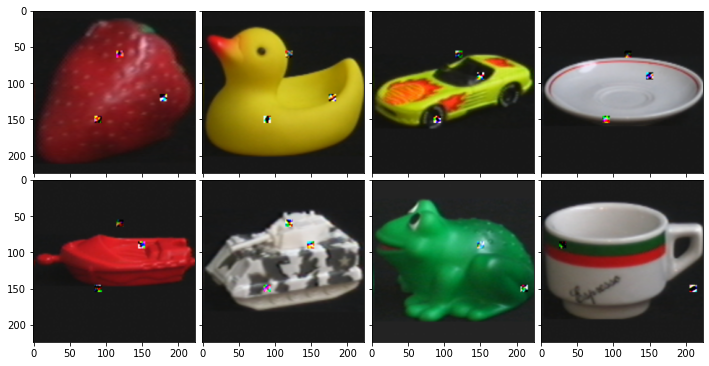

In [21]:
im1_raw = tf.io.read_file(f"/content/gdrive/MyDrive/Data/DAR_data/Pet_images/COIL_DARS_10_3_1.png")
im1 = tf.image.decode_image(im1_raw)
im1 = preprocess(im1)

im2_raw = tf.io.read_file(f"/content/gdrive/MyDrive/Data/DAR_data/Pet_images/COIL_DARS_10_3_2.png")
im2 = tf.image.decode_image(im2_raw)
im2 = preprocess(im2)

im3_raw = tf.io.read_file(f"/content/gdrive/MyDrive/Data/DAR_data/Pet_images/COIL_DARS_10_3_3.png")
im3 = tf.image.decode_image(im3_raw)
im3 = preprocess(im3)

im4_raw = tf.io.read_file(f"/content/gdrive/MyDrive/Data/DAR_data/Pet_images/COIL_DARS_10_3_4.png")
im4 = tf.image.decode_image(im4_raw)
im4 = preprocess(im4)

im5_raw = tf.io.read_file(f"/content/gdrive/MyDrive/Data/DAR_data/Pet_images/COIL_DARS_10_3_5.png")
im5 = tf.image.decode_image(im5_raw)
im5 = preprocess(im5)

im6_raw = tf.io.read_file(f"/content/gdrive/MyDrive/Data/DAR_data/Pet_images/COIL_DARS_10_3_6.png")
im6 = tf.image.decode_image(im6_raw)
im6 = preprocess(im6)

im7_raw = tf.io.read_file(f"/content/gdrive/MyDrive/Data/DAR_data/Pet_images/COIL_DARS_10_3_7.png")
im7 = tf.image.decode_image(im7_raw)
im7 = preprocess(im7)

im8_raw = tf.io.read_file(f"/content/gdrive/MyDrive/Data/DAR_data/Pet_images/COIL_DARS_10_3_8.png")
im8 = tf.image.decode_image(im8_raw)
im8 = preprocess(im8)


fig = plt.figure(figsize=(12., 12.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4, im5, im6, im7, im8]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]

plt.savefig("/content/gdrive/MyDrive/Data/DAR_data/Results/coilpetimages.png")
plt.show()